# Assay and run directory

In [2]:
assay_name = "11bHSD_full"
rundir = "results/11bHSD_ChEMBL/lstm_hc/11bHSD_ChEMBL_cleaned/"
pca_components = 25
kmeans = True 

# Analysis

In [3]:
import os
import numpy as np
import json
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
from utils import data_split, ClusterFps, ecfp4, find_cluster, max_tanimoto_similarity, indexes_identical_fps, average_tanimoto_similarity, tanimoto_similarities, calculateScore, Descriptors, quantitative_analysis

import matplotlib.pyplot as plt
import math
import scipy
import pandas as pd
import seaborn as sns 
import matplotlib
from sklearn.cluster import KMeans

font = {'family' : 'normal',
        'size'   : 25}

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})


matplotlib.rcParams['axes.unicode_minus'] = False
sns.set()
%matplotlib inline 

In [4]:
# Load classifiers and test set for downstream analysis 
scores_test, smiles_test, activities_test, clf = data_split(assay_name)

Reading data from: datasets/11bHSD_full.csv


In [5]:
# Get actives and inactives from test set 
actives = []
inactives = []
smiles_actives = []
smiles_inactives = []

for i, s in enumerate(smiles_test):
    mol = Chem.MolFromSmiles(s)
    if float(activities_test[i])==1:
        actives.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
        smiles_actives.append(s)
    else:
        inactives.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
        smiles_inactives.append(s)


In [6]:
# Extract runs and results from generative models 
runs = []
smiles_list = []
scores_list = []
scores_trajectories = []

print(os.listdir(rundir))

for directory in os.listdir(rundir):
    smiles = []
    scores = []
    trajectories = []
    
    for result_dir in os.listdir(os.path.join(rundir, directory)):
        with open(os.path.join(rundir, directory, result_dir, 'results.json'), 'r') as f:
            results = json.load(f)
            smiles.extend([row['smiles'] for row in results['statistics']][-1])
            scores.extend([row['preds']['scores'] for row in results['statistics']][-1])
            trajectories.extend([np.array(row['preds']['scores']) for row in results['statistics']])
            average_trajectories = np.array([np.array(row['preds']['scores']) for row in results['statistics']])
    if len(smiles)>0:
        runs.append(directory[6:])
        trajectories.append(average_trajectories)
        smiles_list.append(smiles)
        scores_list.append(scores)
        scores_trajectories.append(average_trajectories)

['ecfp4_range_physchem_maxsim_ecfp6', 'ecfp4_range_physchem_maxsim_ecfp4', 'ecfp4_range_physchem_maxsim_ap', 'ecfp4_range_qed', 'ecfp4_range_ecfp4_counts', 'ecfp4_range_ecfp4', 'ecfp4_range_physchem', 'ecfp4_maxsim_ecfp4', 'ecfp4_maxsim_ap', 'ecfp4_maxsim_ecfp6', 'ecfp4_range_physchem_range_ecfp4', 'ecfp4_range_physchem_range_ap', 'ecfp4_range_physchem_range_ecfp6', 'ecfp4_range_physchem_range_ecfp4_counts', 'ecfp4_smiles_validity_ecfp4']


In [7]:
# Cluster the test set for downstream analysis 

X = np.array(actives + inactives)
clustering = KMeans(n_clusters=5, random_state=0).fit(X)

kmeans_clusters = clustering.labels_
training_set_clusters = ClusterFps(actives + inactives, cutoff=0.5)
centroids = [cluster[0] for cluster in training_set_clusters]
fp_list = actives + inactives
centroids_fp = [fp_list[centroid] for centroid in centroids]

In [8]:
# Get all fingerprints to run all analysis faster 
fps_active_as_array = []
fps_active_as_bitv = []
fps_inactive_as_array = []
fps_inactive_as_bitv = []
fps_generated_as_array = []
fps_generated_as_bitv = []

for s in smiles_actives:
    mol = Chem.MolFromSmiles(s)
    fps_active_as_array.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
    fps_active_as_bitv.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    
for s in smiles_inactives:
    mol = Chem.MolFromSmiles(s)
    fps_inactive_as_array.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
    fps_inactive_as_bitv.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    
for i, run in enumerate(runs):
    smiles_generated = smiles_list[i]
    curr_fps_generated_as_array = []
    curr_fps_generated_as_bv = []
    for s in smiles_generated:
        mol = Chem.MolFromSmiles(s)
        curr_fps_generated_as_array.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
        curr_fps_generated_as_bv.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    fps_generated_as_array.append(curr_fps_generated_as_array)
    fps_generated_as_bitv.append(curr_fps_generated_as_bv)
    

In [9]:
# Fits PCA on test set 
pca = PCA(n_components=2).fit(np.concatenate((fps_inactive_as_array,fps_inactive_as_array)))
pca_active = pca.transform(fps_active_as_array)
pca_inactive = pca.transform(fps_inactive_as_array)

pca_generated = []

for i, run in enumerate(runs):
    curr_fps_generated = fps_generated_as_array[i]
    pca_generated.append(pca.transform(curr_fps_generated))

In [10]:
xmin_ymin = np.amin(np.vstack([np.amin(p, axis=0) for p in pca_generated]), axis=0).tolist()

In [11]:
xmax_ymax = np.amax(np.vstack([np.amax(p, axis=0) for p in pca_generated]), axis=0).tolist()

In [12]:
x_lims = [xmin_ymin[0]] + [xmax_ymax[0]]
y_lims = [xmin_ymin[1]] + [xmax_ymax[1]]

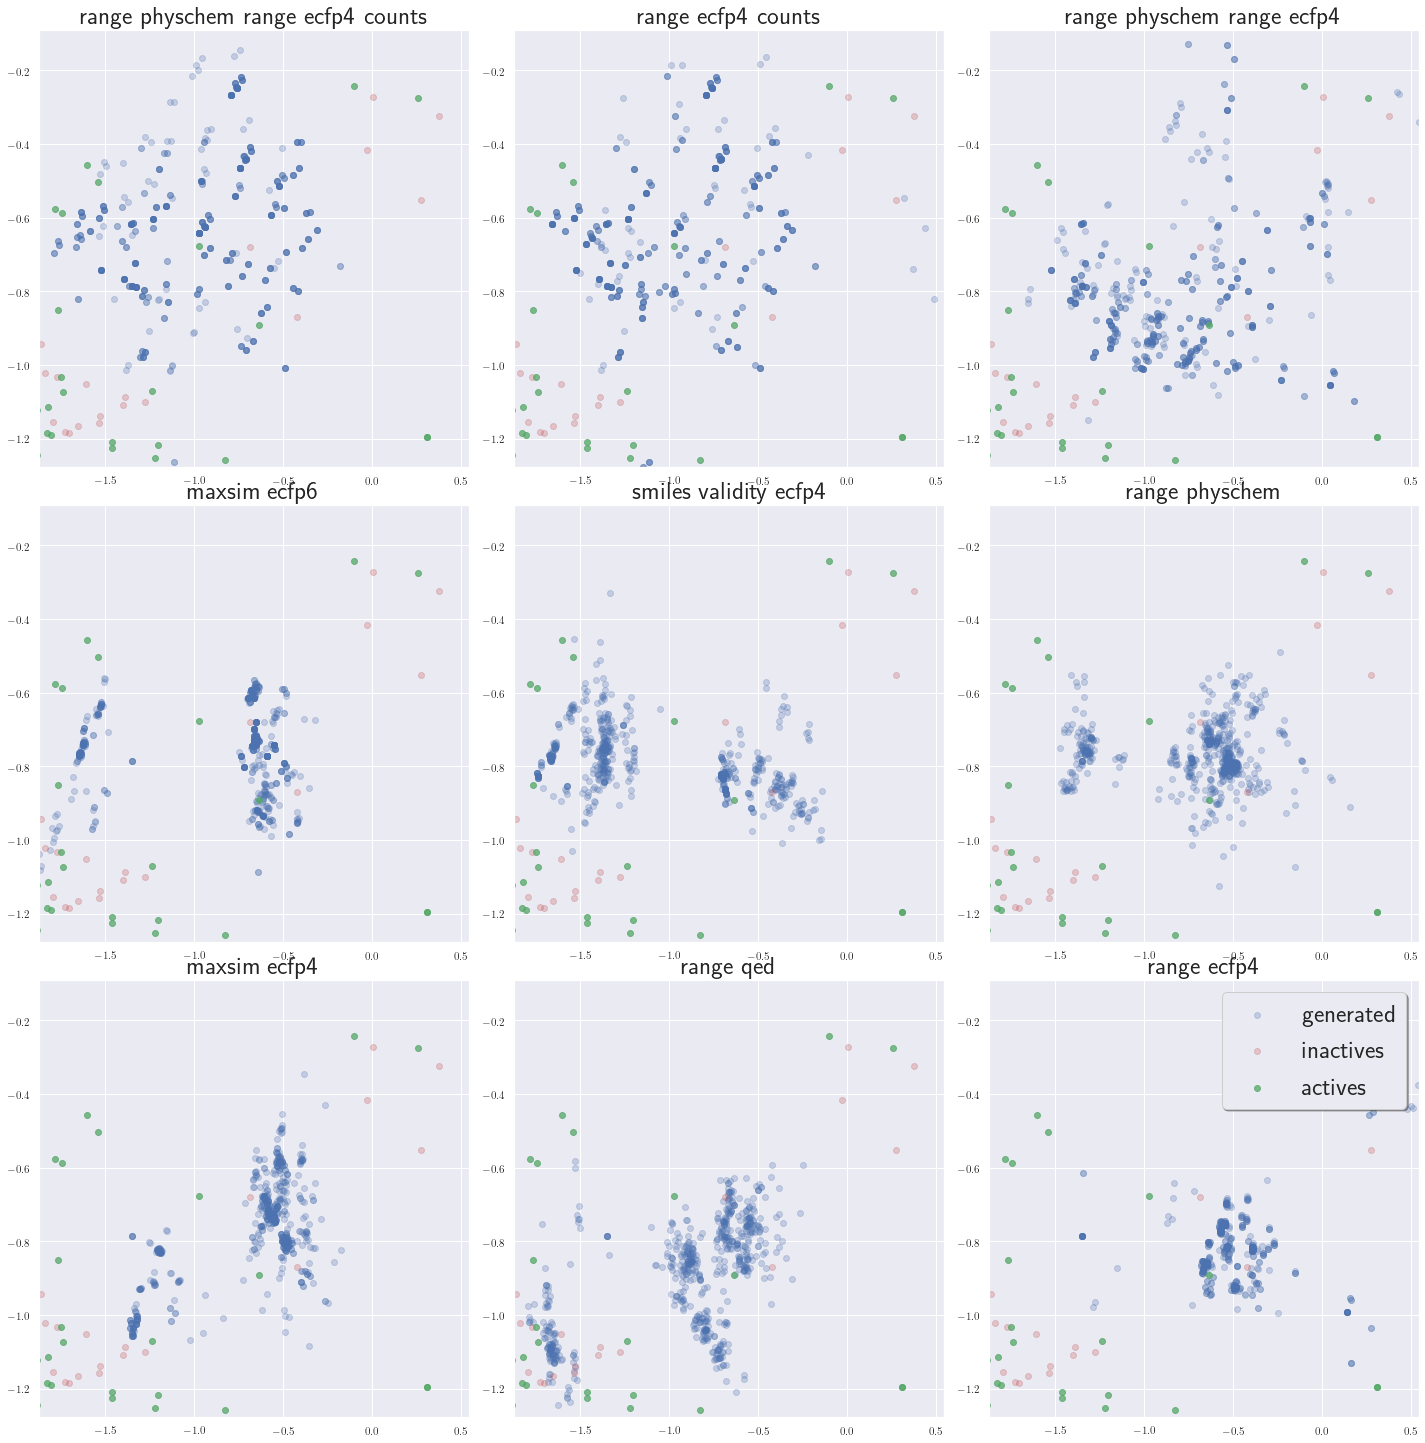

In [13]:
# Displays PCA for selected runs 
runs_to_display = ['range_physchem_range_ecfp4_counts', 'range_ecfp4_counts', 'range_physchem_range_ecfp4',
                   'maxsim_ecfp6', 'smiles_validity_ecfp4', 'range_physchem', 
                   'maxsim_ecfp4', 'range_qed', 'range_ecfp4']
fig, axs = plt.subplots(figsize = (20, 20), nrows=max(1, math.ceil(len(runs_to_display)/3)) , ncols=3)
fig.tight_layout(pad=1.5)

for i, run in enumerate(runs_to_display):
    index = runs.index(run)
    pca_gen = pca_generated[index]
    ax = axs.flatten()[i]
    ax.set_title(run.replace('_', ' '), fontsize='25')
    ax.set_ylim(y_lims)
    ax.set_xlim(x_lims)
    ax.scatter(pca_gen[:, 0], pca_gen[:, 1], c='b', label = 'generated', alpha=0.25)
    ax.scatter(pca_inactive[:, 0], pca_inactive[:, 1], c='r', label = 'inactives', alpha=0.25)
    ax.scatter(pca_active[:, 0], pca_active[:, 1], c='g', label = 'actives', alpha=0.75)
  
    if i==len(runs_to_display)-1: 
        ax.legend(loc='upper right',
              ncol=1, fancybox=True, shadow=True, fontsize='25')
    
plt.savefig('images/11bHSD_full/PCA.pdf', dpi=300)    

In [14]:
# Computes entropy for the different runs 
pca_generated = []
entropies = []
clusters = []
    
pca = PCA(n_components=2).fit(np.concatenate((fps_active_as_array,fps_inactive_as_array)))
pca_active = pca.transform(fps_active_as_array)
pca_inactive = pca.transform(fps_inactive_as_array)
predicted_actives = np.where(clf.predict_proba(ecfp4(smiles_actives))[:, 1]>0.5)[0]

for i, run in enumerate(runs):
    curr_fps_generated = fps_generated_as_array[i]
    curr_fps_generated_bitv = fps_generated_as_bitv[i]    
    pca_generated.append(pca.transform(curr_fps_generated))
    if kmeans:
        curr_clusters = clustering.predict(curr_fps_generated)  
    else:
        curr_clusters = [find_cluster(fp, centroids_fp) for fp in curr_fps_generated_bitv]
    probs = []
    for i in range(len(np.unique(centroids))):
        probs.append(len(np.where(np.array(curr_clusters)==i)[0])/len(curr_clusters))
    entropy = scipy.stats.entropy(probs)/ np.log(len(curr_clusters))
    clusters.append(curr_clusters)
    entropies.append(entropy)

In [15]:
xmin_ymin = np.amin(np.vstack([np.amin(p, axis=0) for p in pca_generated]), axis=0).tolist()
xmax_ymax = np.amax(np.vstack([np.amax(p, axis=0) for p in pca_generated]), axis=0).tolist()
x_lims = [xmin_ymin[0]] + [xmax_ymax[0]]
y_lims = [xmin_ymin[1]] + [xmax_ymax[1]]

Text(0.5, 1.05, 'PCA projections of generated molecules in the training set actives/inactives space\nHighlighting predicted actives')

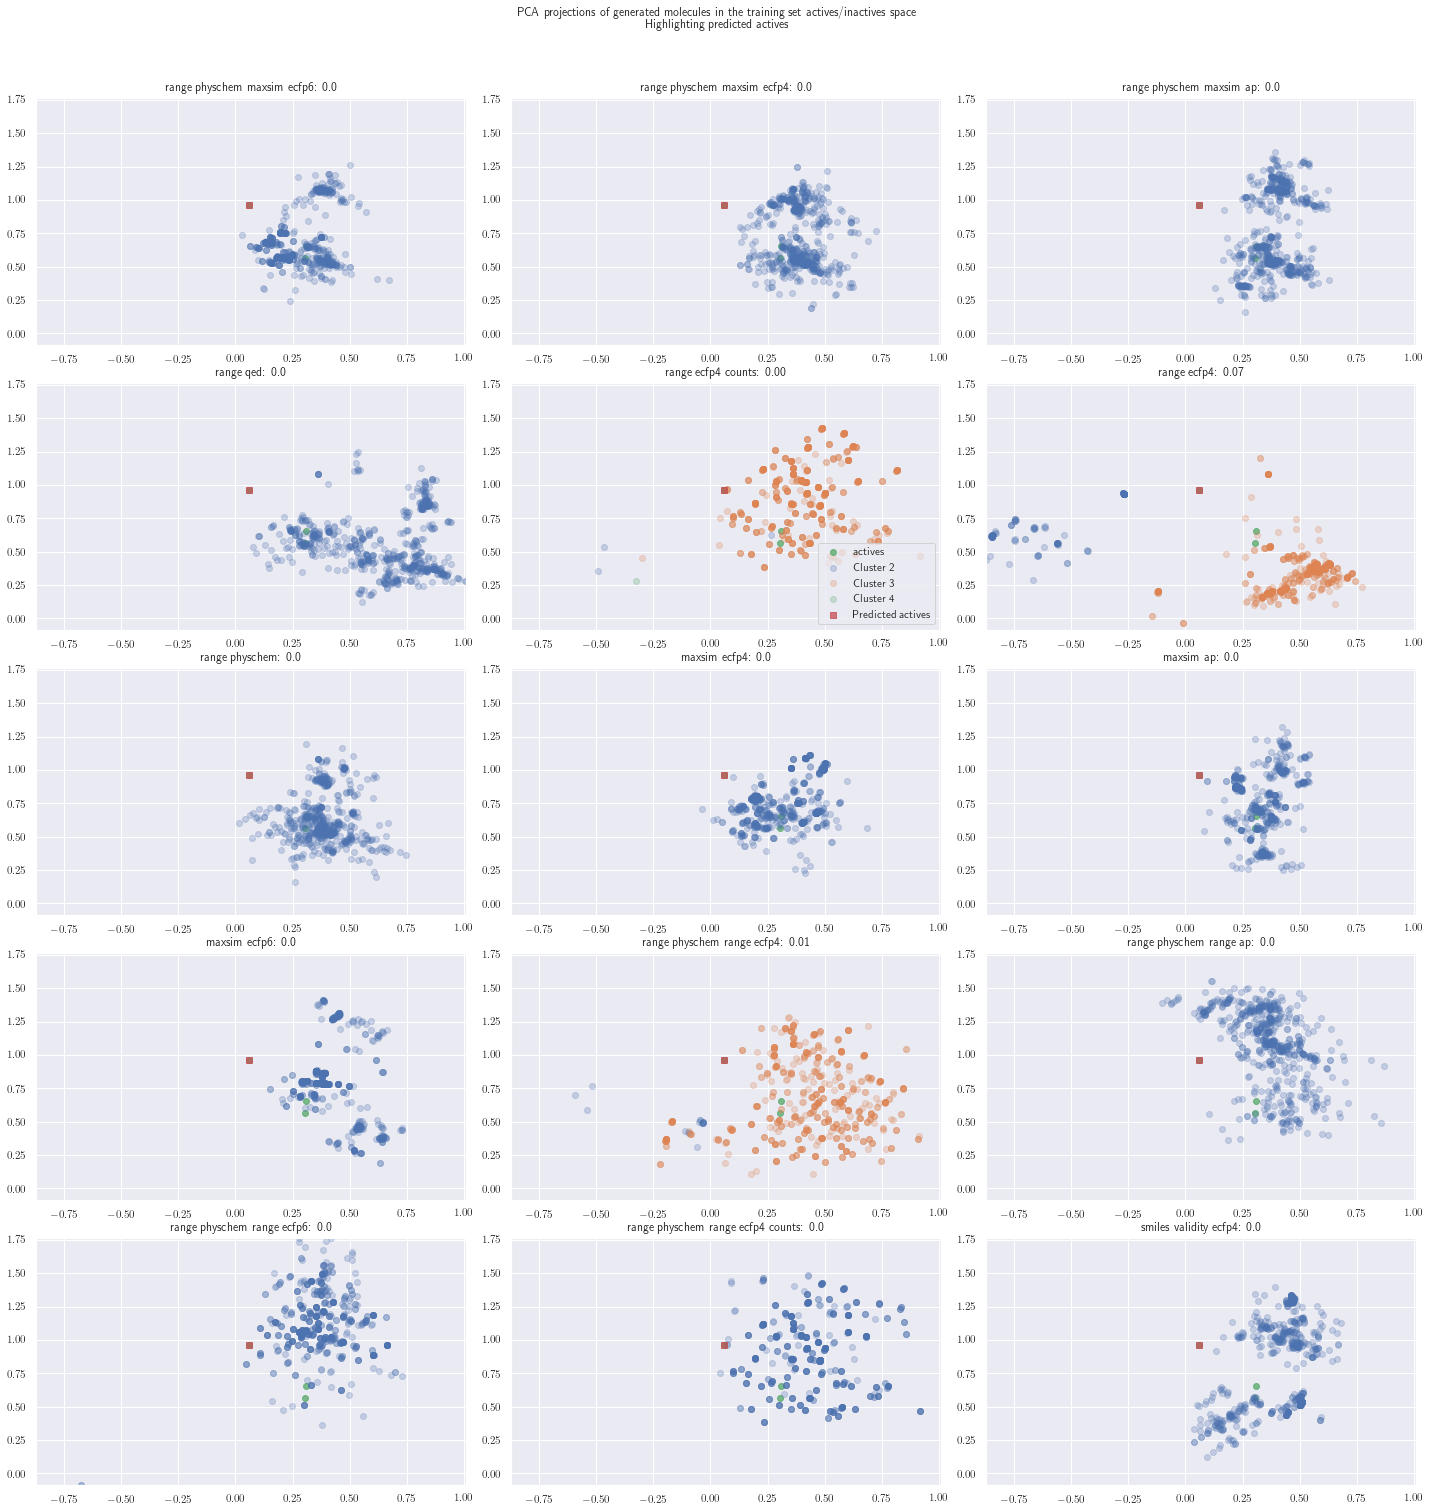

In [16]:
# PCA projection of generated sets with color by clusters
fig, axs = plt.subplots(figsize = (20, 20), nrows=max(1, math.ceil(len(runs)/3)) , ncols=3)
fig.tight_layout(pad=1.5)
no_legend = 0

for i, run in enumerate(runs):
    curr_clusters = clusters[i]
    entropy = entropies[i]
    pca_gen = pca_generated[i]
    ax = axs.flatten()[i]
    ax.set_title(run.replace('_', ' ') + ': ' + str(entropy)[:4])
    ax.set_ylim(y_lims)
    ax.set_xlim(x_lims)
    ax.scatter(pca_active[:, 0], pca_active[:, 1], c='g', label = 'actives', alpha=0.75)    
    for c in np.unique(curr_clusters):
        ax.scatter(pca_gen[:, 0][np.where(curr_clusters==c)], pca_gen[:, 1][np.where(curr_clusters==c)], label= 'Cluster ' + str(c), alpha=0.25)    

    ax.scatter(pca_active[predicted_actives, 0], pca_active[predicted_actives, 1], c='r', label = 'Predicted actives', alpha=0.75, marker='s')
    #ax.scatter(pca_inactive[:, 0], pca_inactive[:, 1], c='r', label = 'inactives', alpha=0.25)
    if len(np.unique(curr_clusters)) == np.amax([len(set(c)) for c in clusters]) and  no_legend == 0 :
        ax.legend(loc=4)
        no_legend = 1
fig.suptitle('PCA projections of generated molecules in the training set actives/inactives space\nHighlighting predicted actives',fontweight ="bold", y=1.05)    

<Figure size 1800x1800 with 0 Axes>

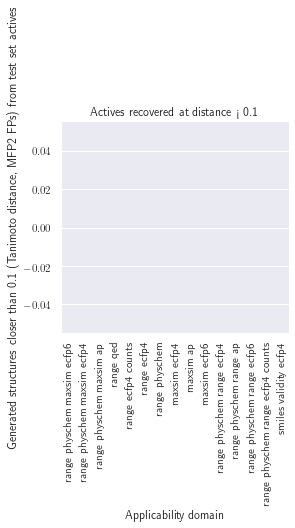

In [17]:
# Displays proportion of actives recovered at distance < 0.1 
fig = plt.figure(figsize=(25, 25))
novel_01 = []
titles = []

predicted_actives = np.where(clf.predict_proba(ecfp4(smiles_actives))[:, 1]>0.5)[0]

for i, run in enumerate(runs):
    curr_fps_generated = fps_generated_as_bitv[i]
    n_new = 0
    for s in np.array(smiles_actives)[predicted_actives]:
        mol = Chem.MolFromSmiles(s)
        if max_tanimoto_similarity([AllChem.GetMorganFingerprintAsBitVect(mol, 2)], curr_fps_generated)>0.9:
            n_new += 1
    novel_01.append(n_new/len(predicted_actives))
    titles.append(run.replace('_', ' '))
    
display_df = pd.DataFrame(zip(titles, novel_01), columns =['Applicability domain', 'Generated structures closer than 0.1 (Tanimoto distance, MFP2 FPs) from test set actives'])
chart = sns.catplot(x="Applicability domain", y="Generated structures closer than 0.1 (Tanimoto distance, MFP2 FPs) from test set actives", kind="bar", data=display_df)
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.title("Actives recovered at distance < 0.1")
plt.show()

#plt.barh(np.arange(len(novel_01)), novel_01, height = 0.25 , label='fraction of actives recovered at distance < 0.1')
#plt.yticks(ticks = np.arange(len(novel_01)), labels = titles, rotation='horizontal')
#plt.legend(loc=0)
   
#fig.suptitle('Fraction of predicted actives in the dataset at distance < 0.1',fontweight ="bold")

<Figure size 1080x1080 with 0 Axes>

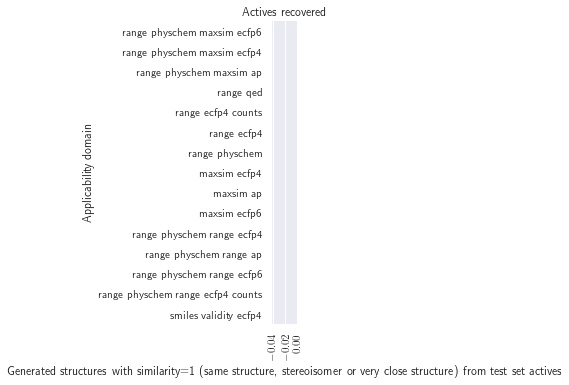

In [18]:
# Displays proportion of actives recovered 
fig = plt.figure(figsize=(15, 15))
novel_recovered = []
titles = []


for i, run in enumerate(runs):
    smiles_generated = smiles_list[i]
    fps_generated = []
    for s in smiles_generated:
        mol = Chem.MolFromSmiles(s)
        fps_generated.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    n_new = 0
    for s in np.array(smiles_actives)[predicted_actives]:
        mol = Chem.MolFromSmiles(s)
        if max_tanimoto_similarity([AllChem.GetMorganFingerprintAsBitVect(mol, 2)], fps_generated)>0.99:
            n_new += 1
    novel_recovered.append(n_new/len(predicted_actives))
    titles.append(run.replace('_', ' '))
display_df = pd.DataFrame(zip(titles, novel_recovered), columns =['Applicability domain', 'Generated structures with similarity=1 (same structure, stereoisomer or very close structure) from test set actives'])
chart = sns.catplot(y="Applicability domain", x="Generated structures with similarity=1 (same structure, stereoisomer or very close structure) from test set actives", kind="bar", data=display_df)
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.title("Actives recovered")
plt.show()

In [19]:
# Computes distances to training set molecules to display enrichment 
training_set_molecules_predicted_actives = np.where(clf.predict_proba(ecfp4(smiles_actives+smiles_inactives))[:, 1]>0.5)[0]
training_set_molecules_predicted_inactives = np.where(clf.predict_proba(ecfp4(smiles_actives+smiles_inactives))[:, 1]<=0.5)[0]
average_similarities = []
max_similarities_actives = []
max_similarities_inactives = []
similarities_actives = []
similarities_inactives = []
similarities_to_closest_actives = []
similarities_to_closest_inactives = []
similarities_to_closest_predicted_actives = []
similarities_to_closest_predicted_inactives = []

ordered_runs = ['maxsim_ecfp4',
                'range_physchem_range_ecfp4_counts']
labels = [
 'maxsim ecfp4',
 
 'range physchem + range ecfp4 counts',]

for i, run in enumerate(ordered_runs):
    curr_fps_generated = fps_generated_as_bitv[runs.index(run)]
    average_similarities.append(average_tanimoto_similarity(fps_active_as_bitv, curr_fps_generated))
    max_similarities_actives.append(max_tanimoto_similarity(fps_active_as_bitv, curr_fps_generated))
    max_similarities_inactives.append(max_tanimoto_similarity(fps_active_as_bitv, curr_fps_generated))
    similarities_actives.append(tanimoto_similarities(fps_active_as_bitv, curr_fps_generated))
    similarities_inactives.append(tanimoto_similarities(fps_inactive_as_bitv, curr_fps_generated))
    curr_similarities_to_closest_actives = []
    for fp in fps_active_as_bitv:
        curr_similarities_to_closest_actives.append(max_tanimoto_similarity([fp], curr_fps_generated))
    similarities_to_closest_actives.append(curr_similarities_to_closest_actives)
    curr_similarities_to_closest_inactives = []
    for fp in fps_inactive_as_bitv:
        curr_similarities_to_closest_inactives.append(max_tanimoto_similarity([fp], curr_fps_generated))
    similarities_to_closest_inactives.append(curr_similarities_to_closest_inactives)
    curr_similarities_to_closest_predicted_actives = []
    curr_similarities_to_closest_predicted_inactives = []
    for j, fp in enumerate(fps_active_as_bitv + fps_inactive_as_bitv):
        if j in training_set_molecules_predicted_actives:
            curr_similarities_to_closest_predicted_actives.append(max_tanimoto_similarity([fp], curr_fps_generated))
        if j in training_set_molecules_predicted_inactives:
            curr_similarities_to_closest_predicted_inactives.append(max_tanimoto_similarity([fp], curr_fps_generated))
    similarities_to_closest_predicted_actives.append(curr_similarities_to_closest_predicted_inactives)
    similarities_to_closest_predicted_inactives.append(curr_similarities_to_closest_predicted_inactives)

In [20]:
# Computes distances to training set molecules to display enrichment 
active_neighbours = []
inactive_neighbours = []

for i, run in enumerate(ordered_runs):
    active_sims = similarities_to_closest_actives[i]
    inactive_sims = similarities_to_closest_inactives[i]
        
    active_sims = np.array(active_sims)
    inactive_sims = np.array(inactive_sims)
    
    sim_tresholds = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.6, 0.5, 0]
    curr_active_neighbours = []
    curr_inactive_neighbours = []
    sim_tresholds.reverse()
    # TODO: reverse 
    for s in sim_tresholds:
        try:
            curr_active_neighbours.append(len(np.where(active_sims>s)[0]))
        except:
            curr_active_neighbours.append(0)
        try:
            curr_inactive_neighbours.append(len(np.where(inactive_sims>s)[0]))
            
        except:
            curr_inactive_neighbours.append(0)
    active_neighbours.append(curr_active_neighbours)
    inactive_neighbours.append(curr_inactive_neighbours)

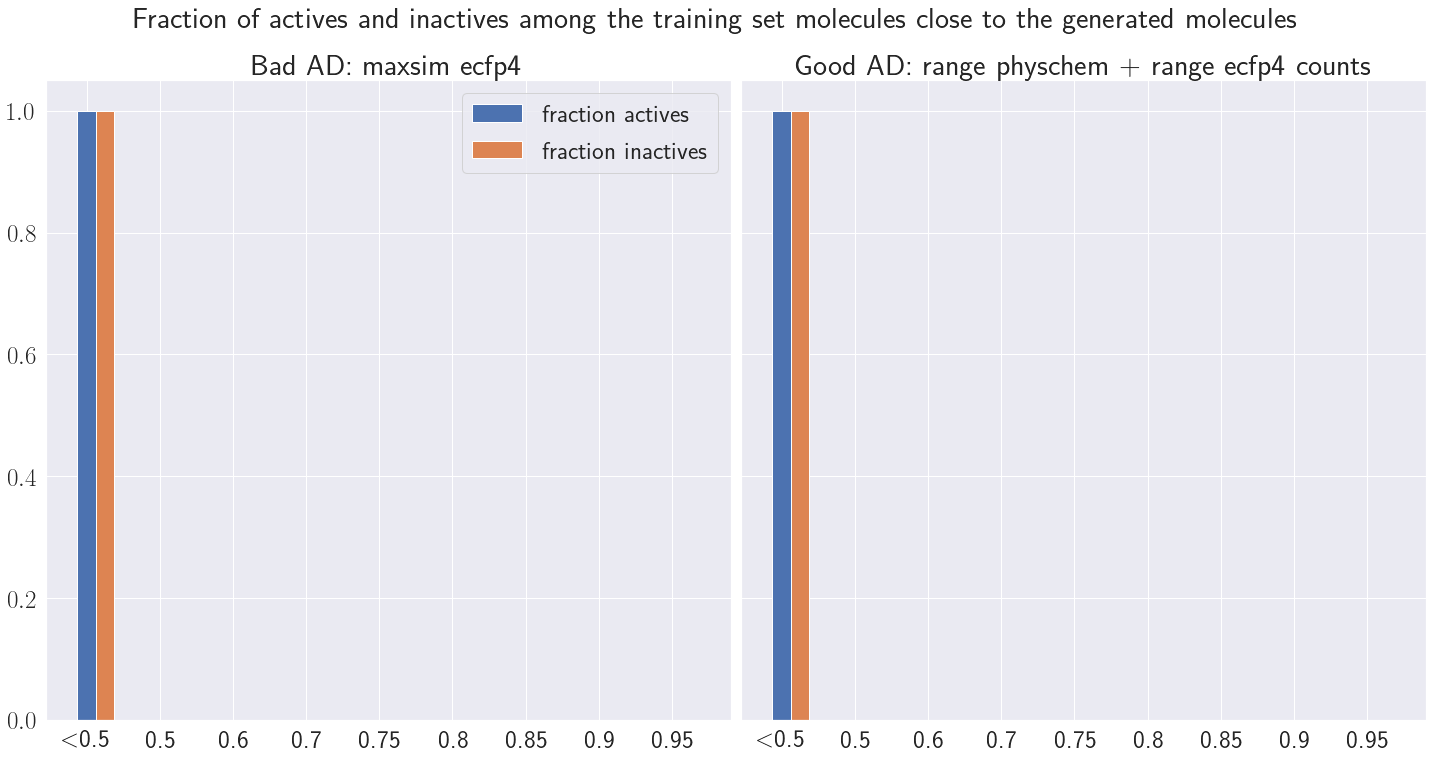

In [21]:
# Compares enrichment on a good and a bad AD 
labels = ['Bad AD: maxsim ecfp4', 'Good AD: range physchem + range ecfp4 counts']
fig, axs = plt.subplots(figsize = (20, 10), nrows=max(1, math.ceil(len(ordered_runs)/2)) , ncols=2, sharey=True)
fig.tight_layout(pad=1.5)
fig.suptitle('Fraction of actives and inactives among the training set molecules close to the generated molecules',fontsize=30, y = 1.05)

for i, run in enumerate(ordered_runs):
    curr_active_neighbours = active_neighbours[i]
    curr_inactive_neighbours = inactive_neighbours[i]
    ax = axs.flatten()[i]
    ax.set_title(labels[i], fontsize=30)
    ax.bar(np.arange(len(sim_tresholds)), np.array(curr_active_neighbours)/len(fps_active_as_bitv), width=0.25, label='fraction actives')
    ax.bar(np.arange(len(sim_tresholds))+ 0.25, np.array(curr_inactive_neighbours)/len(fps_inactive_as_bitv), width=0.25, label='fraction inactives')
    
    ax.set_xticks(np.arange(len(sim_tresholds)))
    ax.set_xticklabels(['$<$0.5'] + sim_tresholds[1:])
    ax.tick_params(axis='both', which='major', labelsize=25)

    ax.set_ylim(0, 1.05)
    if i == 0 :
        ax.legend(loc=0, fontsize=25)
        
plt.tight_layout()
plt.savefig('images/11bHSD_full/enrichment.pdf', dpi=300)

In [22]:
# Computes QED and SAS for the test set 
qed_dataset = []
sas_dataset = []
for s in smiles_actives + smiles_inactives:
    mol = Chem.MolFromSmiles(s)
    qed_dataset.append(Descriptors.qed(mol))
    sas_dataset.append(calculateScore(mol))

In [23]:
# Computes QED and SAS for generated sets 
QED = []
SAS = []

SAS_for_results = []
QED_for_results = []
ad = []
for i, run in enumerate(runs):
    avg_sims = []
    max_sim = []
    smiles_generated = smiles_list[i]
    qed_generated = []
    sas_generated = []
    for s in smiles_generated:
        mol = Chem.MolFromSmiles(s)
        qed_generated.append(Descriptors.qed(mol))
        sas_generated.append(calculateScore(mol))

    
        
        QED.append(Descriptors.qed(mol))
        SAS.append(calculateScore(mol))
        ad.append(run)
    SAS_for_results.append(sas_generated)
    QED_for_results.append(qed_generated)

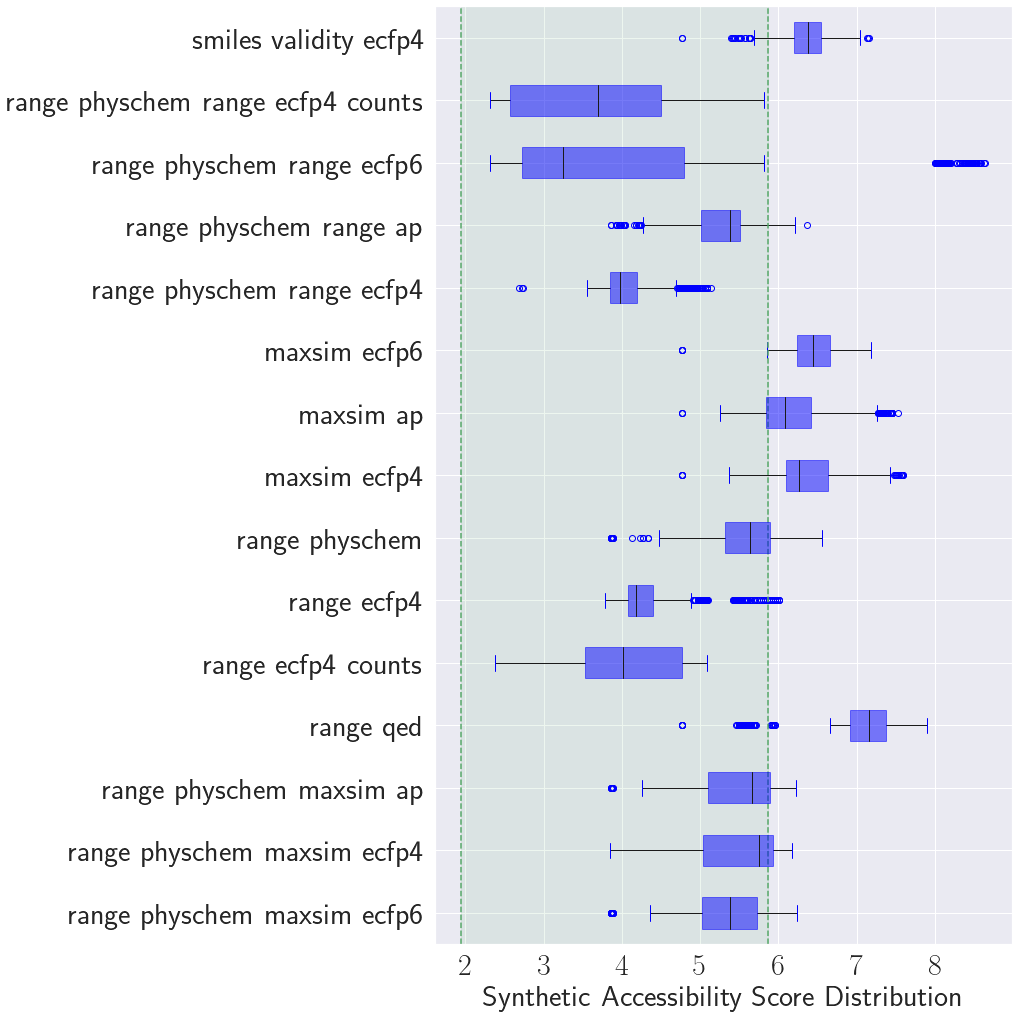

In [24]:
# Plots SAS distributions 
matplotlib.rcParams.update({'font.size': 35})

plt.figure(figsize= (15, 15))

c = 'blue'
box = plt.boxplot(SAS_for_results, labels = [x.replace('_', ' ') for x in runs], vert=False, patch_artist=True,
            boxprops=dict(facecolor=c, color=c, alpha=0.5),
            capprops=dict(color=c),
            whiskerprops=dict(color='k'),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='k'),)



plt.axvline(np.percentile(sas_dataset, 100), ls='--', label='Dataset extreme QED values', c='g')
plt.axvline(np.percentile(sas_dataset, 0), ls='--', c='g')
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between([np.percentile(sas_dataset, 0), np.percentile(sas_dataset, 100)], ymin, ymax, color='g', alpha=0.1, label = 'Valid QED')
plt.xlabel("Synthetic Accessibility Score Distribution", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)


plt.tight_layout()
plt.savefig('images/11bHSD_full/SAS_distribution.pdf', dpi=300)

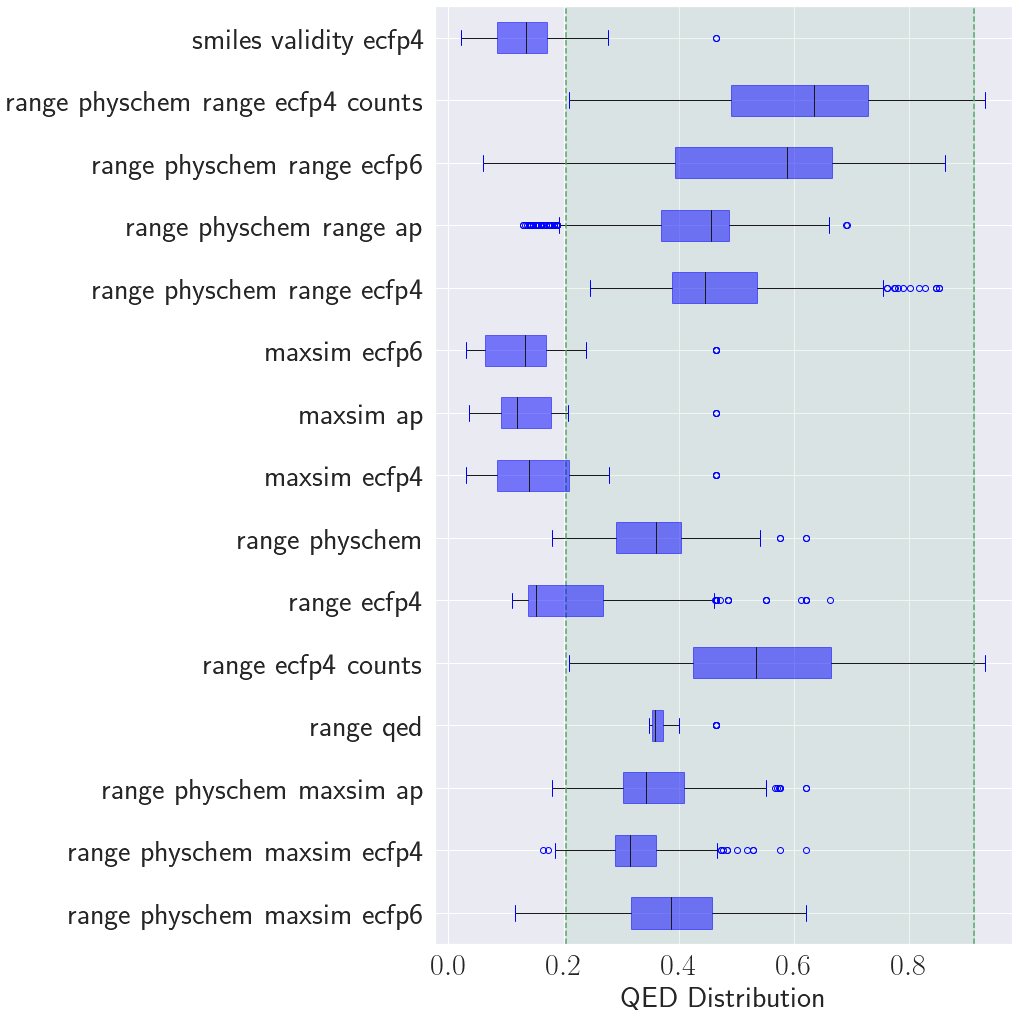

In [25]:
# Plots QED distributions 
plt.figure(figsize= (15, 15))
c = 'blue'
box = plt.boxplot(QED_for_results, labels = [x.replace('_', ' ') for x in runs], vert=False, patch_artist=True,
            boxprops=dict(facecolor=c, color=c, alpha=0.5),
            capprops=dict(color=c),
            whiskerprops=dict(color='k'),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='k'),)

plt.axvline(np.percentile(qed_dataset, 100), ls='--', label='Dataset extreme QED values', c='g')
plt.axvline(np.percentile(qed_dataset, 0), ls='--', c='g')
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between([np.percentile(qed_dataset, 0), np.percentile(qed_dataset, 100)], ymin, ymax, color='g', alpha=0.1, label = 'Valid QED')
plt.xlabel("QED Distribution", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)


plt.tight_layout()
plt.savefig('images/11bHSD_full/QED_distribution.pdf', dpi=300)

# Comparing different AD's outputs

In [26]:
from utils import qualitative_analysis, return_distribution_cycle_size, return_distribution_mw, return_distribution_halogen, return_distribution_heteroatoms, return_distribution_radicals, return_distribution_sulphur, qualitative_analysis

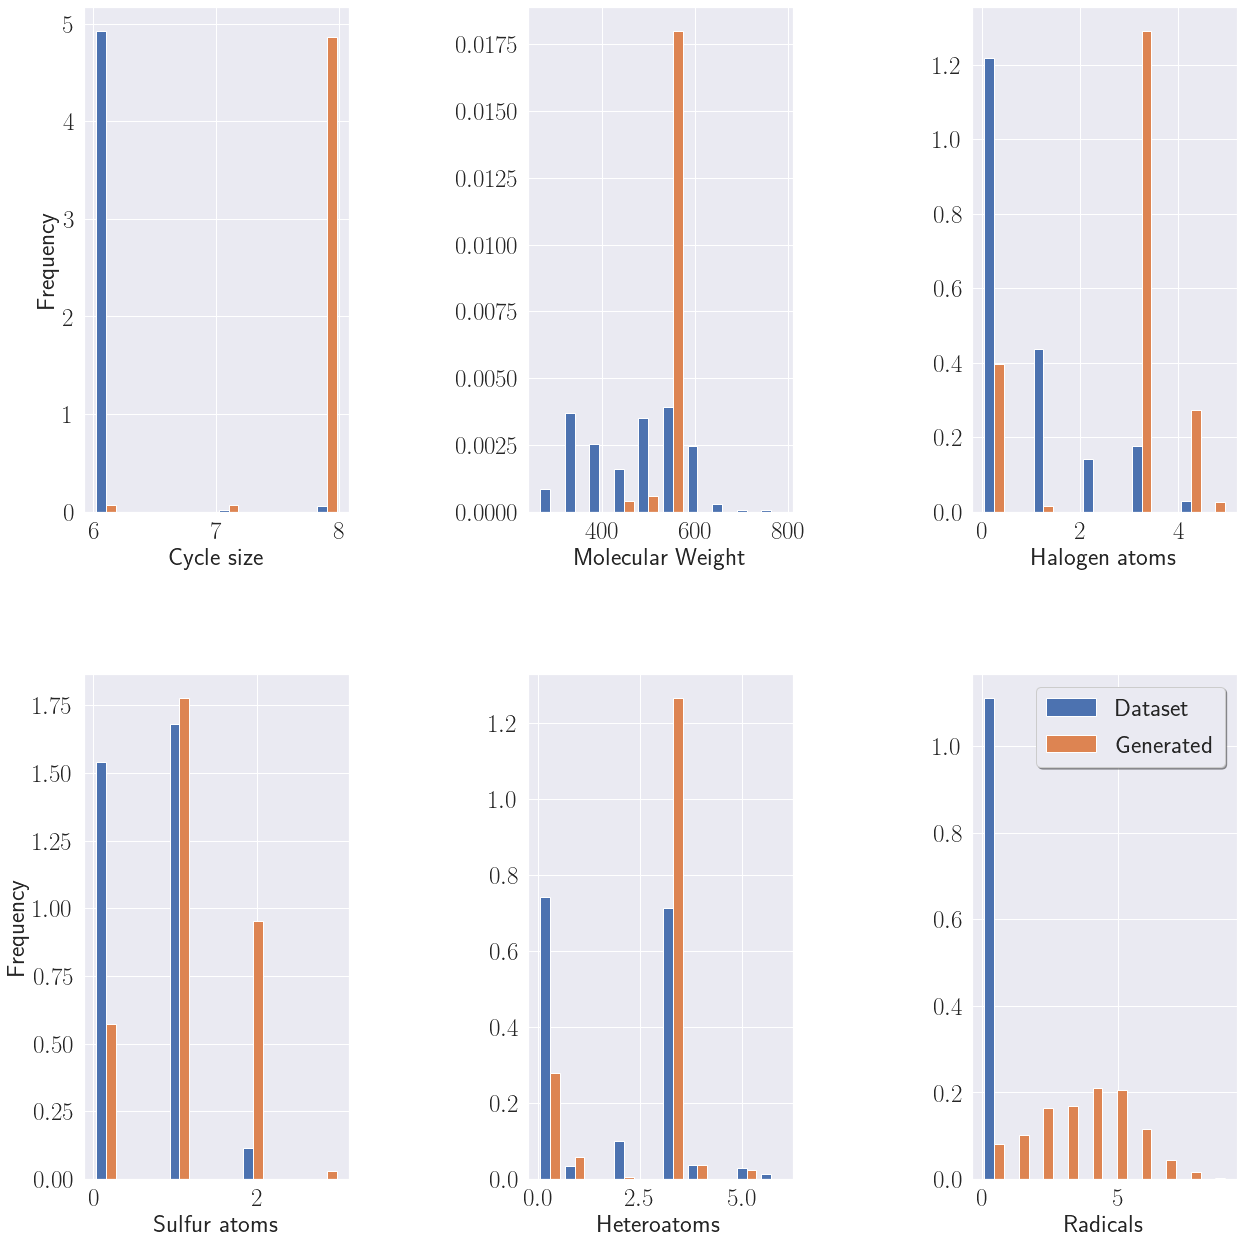

In [27]:
# Example on maxsim AP applicability domain of comparison of properties distribution with the test set 
properties = ['cycle_size', 'mw', 'halogen', 'sulphur', 'heteroatoms', 'radicals']
properties_name = ['Cycle size', 'Molecular Weight', 'Halogen atoms', 'Sulfur atoms', 'Heteroatoms', 'Radicals']

fig, axs = plt.subplots(figsize = (20, 20), nrows=max(1, math.ceil(len(properties)/3)) , ncols=3)

fig.tight_layout(pad=1.5)
for i, prop in enumerate(properties):
    ax = axs.flatten()[i]
    ax.set_xlabel(properties_name[i], fontsize='25')
    ref_distribution = locals()["return_distribution_" + prop](smiles_test)
    generated_distribution = locals()["return_distribution_" + prop](smiles_list[0])
    if i%3==0:
        ax.set_ylabel("Frequency", fontsize='25')
    ax.hist([ref_distribution, generated_distribution], label=['Dataset', 'Generated'], density=True)
    if i==len(properties)-1:
        ax.legend(loc='upper right',
              ncol=1, fancybox=True, shadow=True, fontsize='25')
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.tick_params(axis='both', which='minor', labelsize=25)
fig.tight_layout(pad=3.0)


In [28]:
best_methods = ['range_physchem_range_ap', 'range_ecfp4_counts', 'range_physchem_range_ecfp4_counts', 'range_physchem_range_ecfp6', 'range_physchem_range_ecfp4']

In [29]:
# Computes average similarities between runs from the "best methods"
average_similarities = []
max_similarities = []
common_molecules = {}
for i, run in enumerate(best_methods):
    avg_sims = []
    max_sim = []
    smiles_generated = smiles_list[i]
    fps_generated = fps_generated_as_bitv[i]
    for j, comparison_run in enumerate(best_methods):
        smiles_generated = smiles_list[j]
        fps_other = fps_generated_as_bitv[j]
        if j<i:
            indexes, indexes_other = indexes_identical_fps(fps_generated, fps_other)
            common_molecules[run + '_vs_' + comparison_run] = [indexes, indexes_other] 
        avg_sims.append(average_tanimoto_similarity(fps_generated, fps_other))
        max_sim.append(max_tanimoto_similarity(fps_generated, fps_other))
    average_similarities.append(avg_sims)
    max_similarities.append(max_sim)

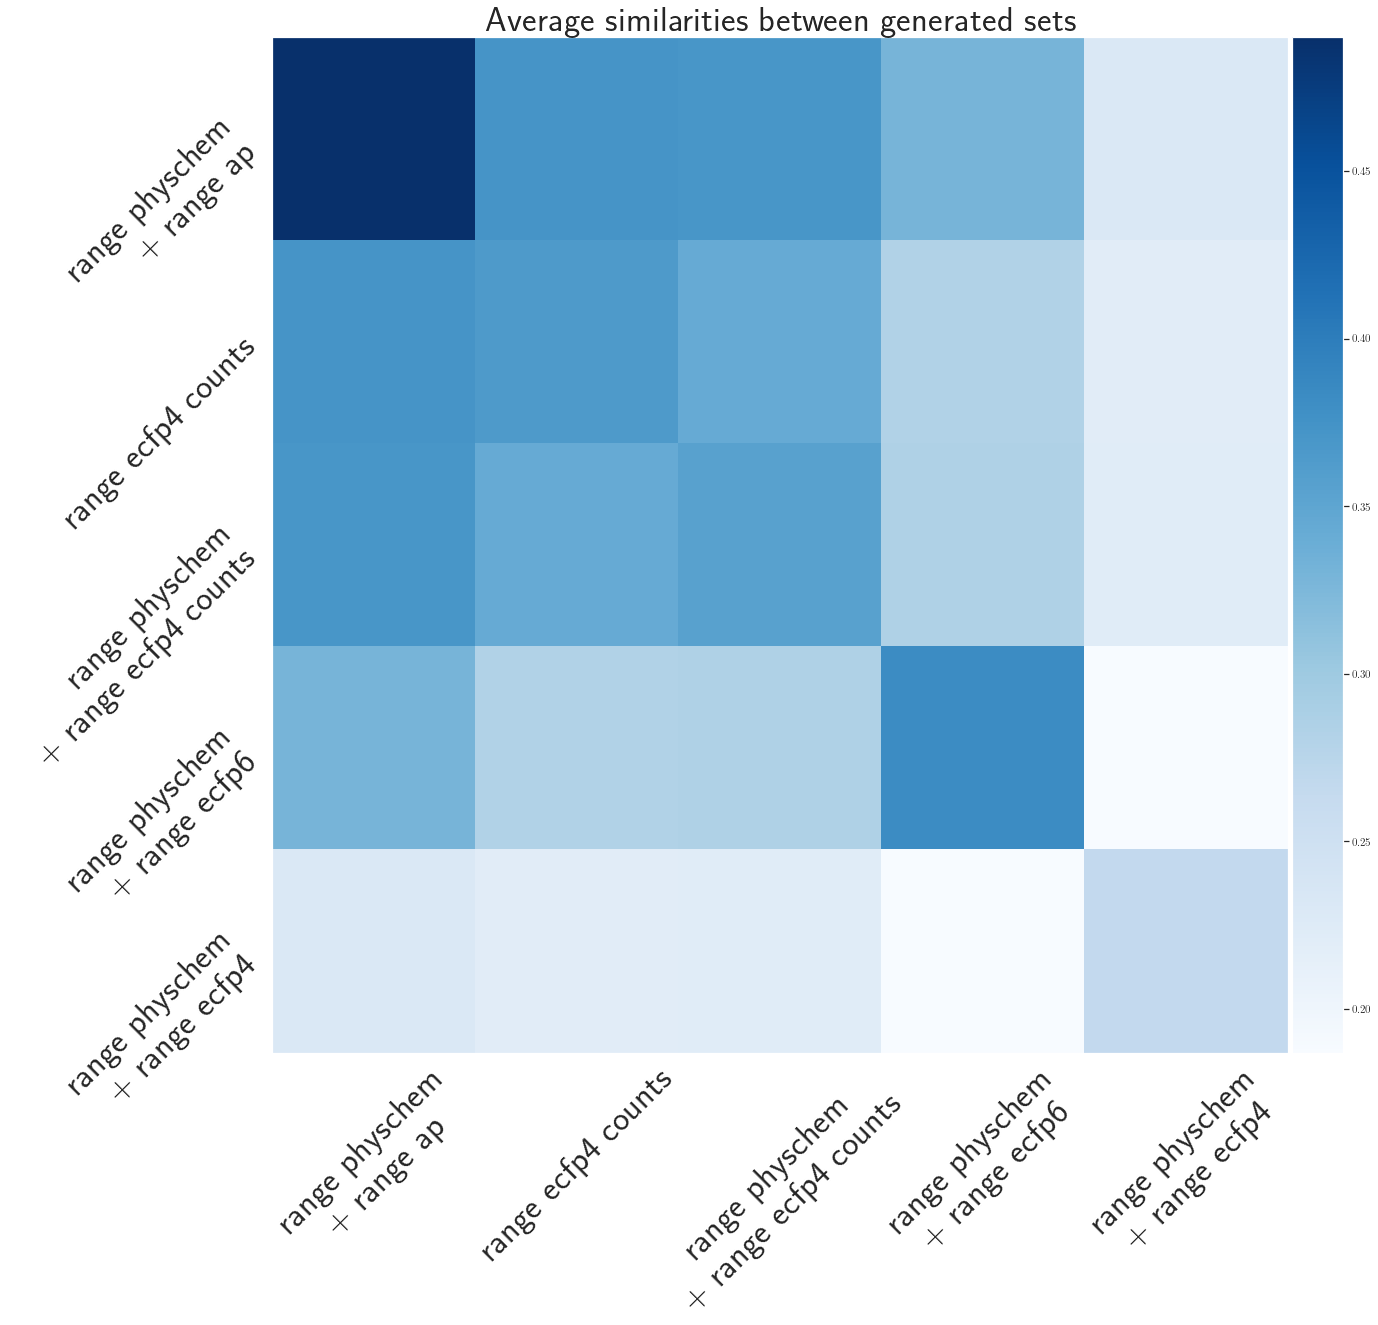

In [30]:
# Displays average generated set - generated set similarities 
from mpl_toolkits.axes_grid1 import make_axes_locatable

labels = ['range physchem + range ap', 'range ecfp4 counts', 'range physchem + range ecfp4 counts', 'range physchem + range ecfp6', 'range physchem + range ecfp4']
labels_xaxis = ['range physchem \n + range ap', 'range ecfp4 counts', 'range physchem \n + range ecfp4 counts', 'range physchem \n + range ecfp6', 'range physchem \n + range ecfp4']


fig, ax = plt.subplots(figsize = (20, 20), nrows=1 , ncols=1)

fig.tight_layout(pad=1.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)



ax.set_title("Average similarities between generated sets", fontsize=35)

im = ax.imshow(np.array(average_similarities), cmap='Blues')
ax.set_yticks(ticks=range(len(best_methods)))
ax.set_xticks(ticks=range(len(best_methods)))
ax.set_xticklabels(labels_xaxis, rotation=45)
ax.set_yticklabels(labels_xaxis, rotation=45)
ax.tick_params(axis='both', which='major', labelsize=35)
ax.tick_params(axis='both', which='minor', labelsize=35)
#plt.colorbar()
fig.tight_layout(pad=3.0)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.grid(False)

plt.tight_layout()
plt.savefig('images/11bHSD_full/similarities.pdf', dpi=300)

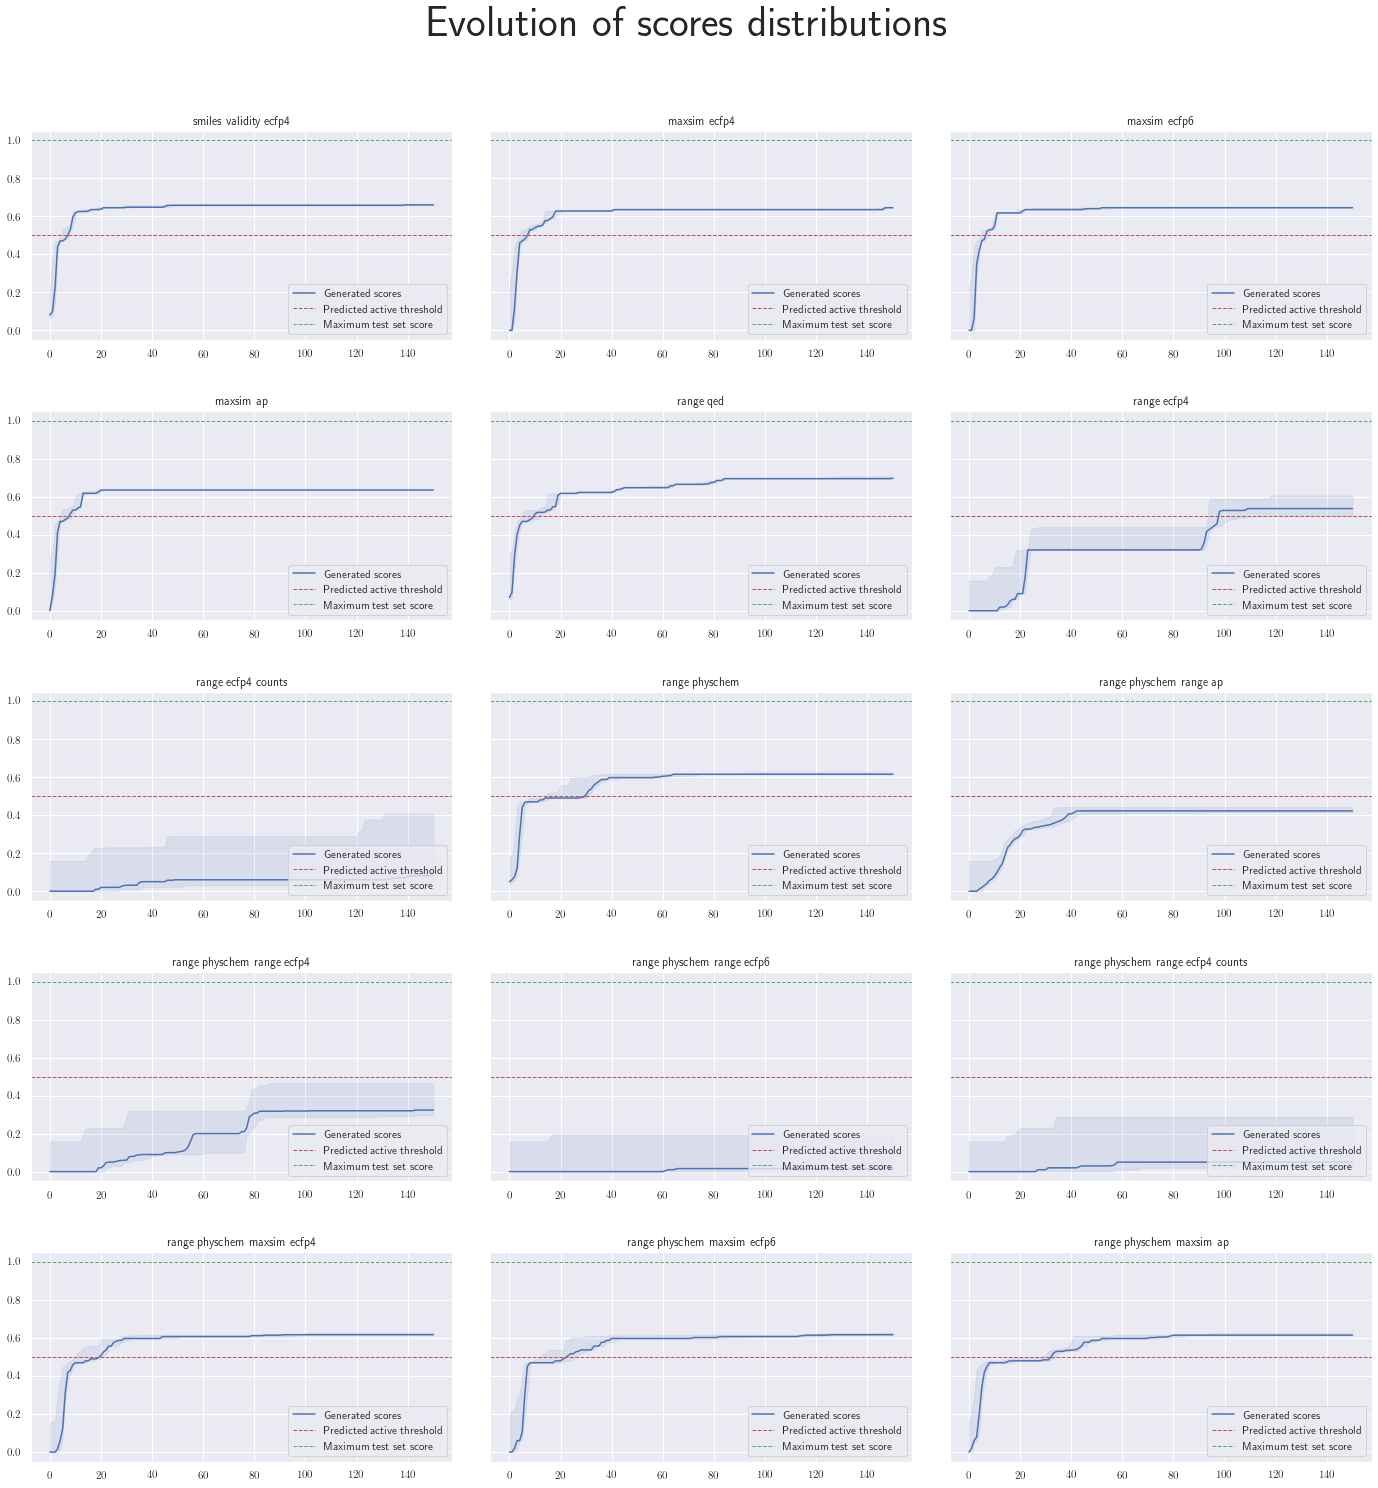

In [31]:
# Scores distribution throughout optimization for the different AD
ordered_runs = ['smiles_validity_ecfp4', 'maxsim_ecfp4', 'maxsim_ecfp6', 'maxsim_ap', 'range_qed',
                'range_ecfp4', 'range_ecfp4_counts', 'range_physchem', 'range_physchem_range_ap', 'range_physchem_range_ecfp4', 'range_physchem_range_ecfp6',
                'range_physchem_range_ecfp4_counts', 'range_physchem_maxsim_ecfp4', 'range_physchem_maxsim_ecfp6', 
                'range_physchem_maxsim_ap']
fig, axs = plt.subplots(figsize = (20, 20), nrows=max(1, math.ceil(len(ordered_runs)/3)) , ncols=3, sharey=True)

fig.tight_layout(pad=1.5)

for i, run in enumerate(ordered_runs):
    ax = axs.flatten()[i]
    ax.set_title(run.replace('_', ' '))
    scores = np.array(scores_trajectories[runs.index(run)])
    median = np.median(scores, 1)
    q25 = np.percentile(scores, 5, axis=1)
    q75 = np.percentile(scores, 95, axis=1)
    ax.plot(median, c='b', label='Generated scores')
    ax.fill_between(
        np.arange(median.shape[0]), q25, q75, alpha=.1, color='b')
    ax.axhline(y=0.5, linewidth=1, ls='--', color='r', label='Predicted active threshold')
    ax.axhline(y=np.max(scores_test), linewidth=1, ls='--', color='g', label='Maximum test set score')
    ax.legend(loc=4)
fig.suptitle('Evolution of scores distributions', fontweight ="bold", y=1.05)
plt.tight_layout()
plt.savefig('images/11bHSD_full/scores_distribution.pdf', dpi=300)

In [32]:
# Computes properties for general analysis of the results 
internal_diversity = [average_tanimoto_similarity(fps_generated_as_bitv[i],  fps_generated_as_bitv[i]) for i in range(len(runs))]
average_scores = np.mean(scores_list, axis=0)
mean_dataset = np.mean(scores_test)
average_SAS = np.array([np.mean(x) for x in SAS_for_results])
average_QED = np.array([np.mean(x) for x in QED_for_results])
top_SAS = np.percentile(sas_dataset, 100)
bottom_QED = np.percentile(qed_dataset, 0)
quantitative_analysis_results = [quantitative_analysis(smiles, smiles_test) for smiles in smiles_list]
cycle_size = [x[0] for x in quantitative_analysis_results]
mw = [x[1] for x in quantitative_analysis_results]
heteroatoms = [x[2] for x in quantitative_analysis_results]
radicals = [x[3] for x in quantitative_analysis_results]

In [33]:
# Global results 
import pandas as pd 

ordered_runs = ['smiles_validity_ecfp4', 'maxsim_ecfp4', 'maxsim_ecfp6', 'maxsim_ap', 'range_qed',
                'range_ecfp4', 'range_ecfp4_counts', 'range_physchem', 'range_physchem_range_ap', 'range_physchem_range_ecfp4', 'range_physchem_range_ecfp6',
                'range_physchem_range_ecfp4_counts', 'range_physchem_maxsim_ecfp4', 'range_physchem_maxsim_ecfp6', 
                'range_physchem_maxsim_ap']
df = pd.DataFrame(list(zip(entropies, 1 - np.array(internal_diversity), 100 * novel_01, 100 * novel_recovered,
                           100 * np.array([np.mean(x<top_SAS) for x in SAS_for_results]),
                           100 * np.array([np.mean(x>bottom_QED) for x in QED_for_results]), cycle_size, mw, heteroatoms, radicals)),
               columns =['Entropies', 'Internal diversity','Actives recovered at distance <0.1', 
                         'Actives recovered', 'Valid SAS', 'Valid QED', 'Valid cycle sizes',
                        'Valid MW', 'Valid het-het bonds', 'Unpaired electrons'],
                 index = runs)

df = df.reindex(ordered_runs)
df = df.round({'Entropies': 2, 'Internal diversity': 2, 'Actives recovered at distance <0.1': 1, 
                         'Actives recovered':1, 'Valid SAS':1, 'Valid QED':1, 'Valid cycle sizes':1,
                        'Valid MW':1, 'Valid het-het bonds':1, 'Unpaired electrons':1})

df_dummy = pd.DataFrame(list(zip([0, 1], [0, 1], [0, 100], [0, 100], [0, 100], [0, 100], [0, 100], [0, 100], [0, 100], [0, 100])),
               columns =['Entropies', 'Internal diversity','Actives recovered at distance <0.1', 
                         'Actives recovered', 'Valid SAS', 'Valid QED', 'Valid cycle sizes',
                        'Valid MW', 'Valid het-het bonds', 'Unpaired electrons'],
                 index = ["dummy_low", "dummy_high"])
df = df.append(df_dummy)

s = df.style.background_gradient(cmap = 'BuGn', axis = 0, subset=['Entropies', 'Actives recovered at distance <0.1',
       'Actives recovered', 'Valid SAS',
       'Valid QED', 'Internal diversity', 'Valid cycle sizes',
                        'Valid MW', 'Valid het-het bonds', 'Unpaired electrons'])
s.format({'Entropies': "{:.2f}", 'Internal diversity': "{:.2f}", 'Actives recovered at distance <0.1': "{:.1f}", 
                         'Actives recovered':"{:.1f}", 'Valid SAS':"{:.1f}", 'Valid QED':"{:.1f}", 'Valid cycle sizes':"{:.1f}",
                        'Valid MW':"{:.1f}", 'Valid het-het bonds':"{:.1f}", 'Unpaired electrons':"{:.1f}"})


,Entropies,Internal diversity,Actives recovered at distance <0.1,Actives recovered,Valid SAS,Valid QED,Valid cycle sizes,Valid MW,Valid het-het bonds,Unpaired electrons
smiles_validity_ecfp4,0.00,0.64,0.0,0.0,5.3,16.1,18.6,8.3,94.7,59.1
maxsim_ecfp4,0.00,0.56,0.0,0.0,9.8,28.0,13.6,0.6,59.7,65.9
maxsim_ecfp6,0.00,0.56,0.0,0.0,0.9,12.3,30.2,3.6,50.8,45.9
maxsim_ap,0.00,0.64,0.0,0.0,40.6,1.1,40.2,54.8,85.3,45.0
range_qed,0.00,0.62,0.0,0.0,19.4,100.0,20.0,22.7,30.0,80.5
range_ecfp4,0.07,0.48,0.0,0.0,96.2,26.7,85.2,75.5,98.4,100.0
range_ecfp4_counts,0.01,0.73,0.0,0.0,100.0,100.0,91.4,99.7,100.0,100.0
range_physchem,0.00,0.56,0.0,0.0,72.7,99.1,100.0,100.0,100.0,19.5
range_physchem_range_ap,0.00,0.72,0.0,0.0,98.0,88.6,100.0,100.0,100.0,54.4
range_physchem_range_ecfp4,0.02,0.60,0.0,0.0,100.0,100.0,100.0,100.0,100.0,100.0


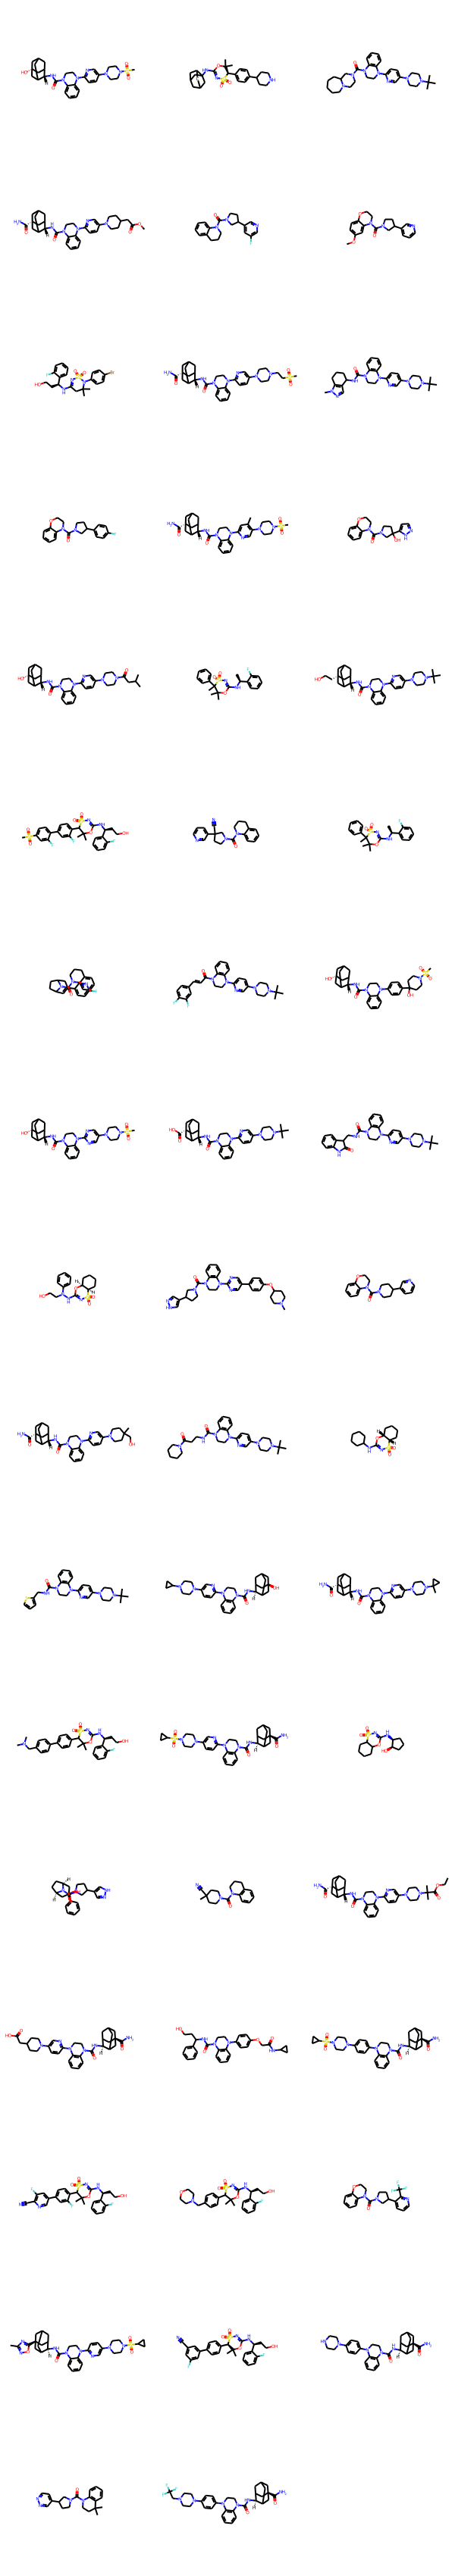

In [39]:
MolsToGridImage([Chem.MolFromSmiles(s) for s in smiles_test])

In [35]:
# Get latex code to display as table in article manuscript 
string = s.to_latex(convert_css=True)
string   

['range_physchem_maxsim_ecfp6',
 'range_physchem_maxsim_ecfp4',
 'range_physchem_maxsim_ap',
 'range_qed',
 'range_ecfp4_counts',
 'range_ecfp4',
 'range_physchem',
 'maxsim_ecfp4',
 'maxsim_ap',
 'maxsim_ecfp6',
 'range_physchem_range_ecfp4',
 'range_physchem_range_ap',
 'range_physchem_range_ecfp6',
 'range_physchem_range_ecfp4_counts',
 'smiles_validity_ecfp4']

/opt/local/anaconda3/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:243: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


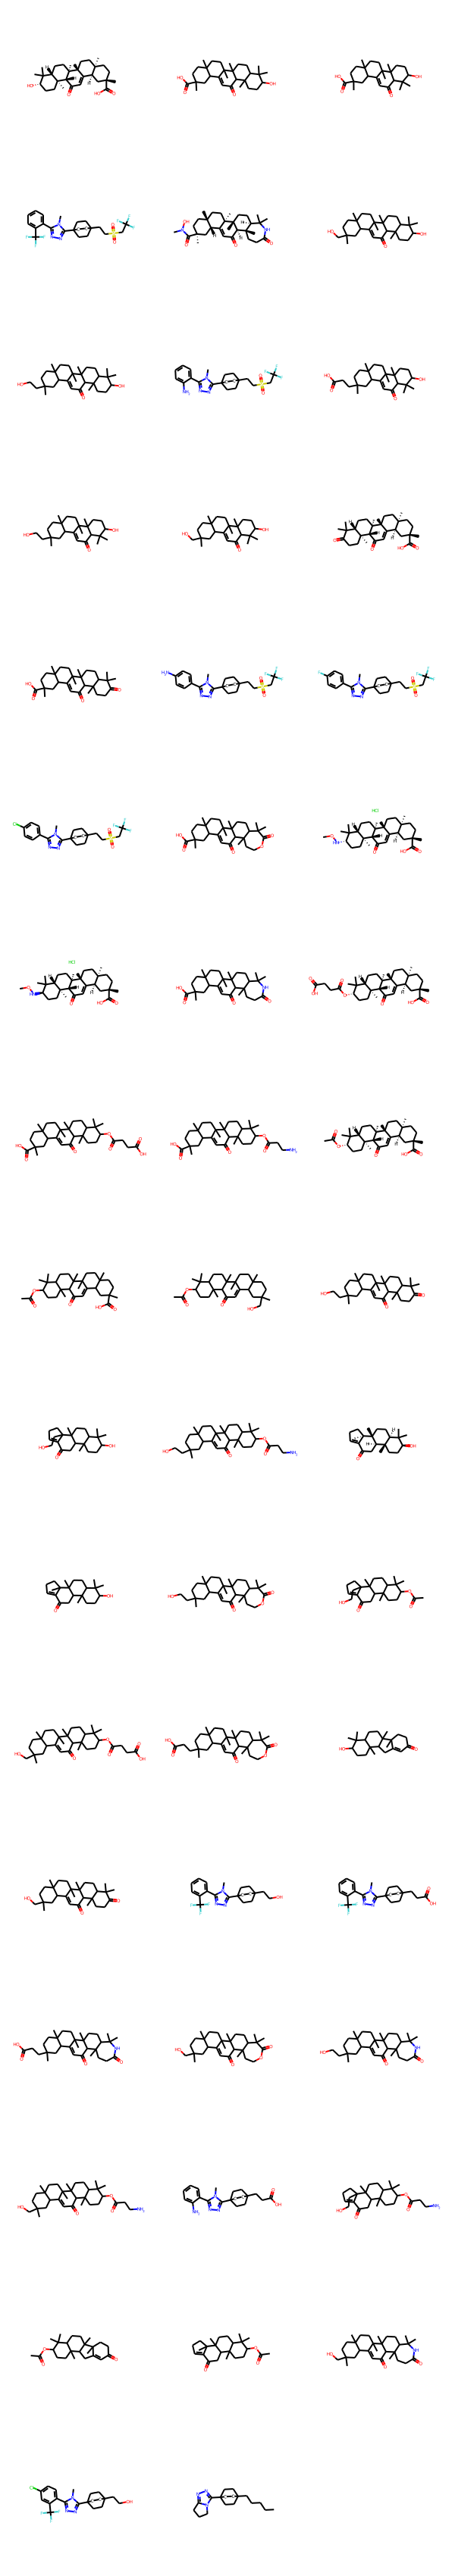

In [36]:
from rdkit.Chem.Draw import MolsToGridImage
ad = 'range_physchem_range_ecfp4_counts'
MolsToGridImage([Chem.MolFromSmiles(s) for s in smiles_list[runs.index(ad)]])